In [1]:
import os
import ipyparallel as ipp
rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()
print(len(rc[:]))

76


In [5]:
import random
random.seed(0)
sample =random.sample(range(len()), )
print(sample)

[14, 7, 13]


In [ ]:
%%px
from cosmikyu import visualization as covis
from cosmikyu import gan, config, datasets, transforms, stats, mpi
import numpy as np
import os
import torchvision.transforms as pytransforms
import matplotlib.pyplot as plt
import torch as tf
import mlflow
from orphics import maps
from pixell import enplot, enmap

mpi.init(True)

data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
cuda = True
compt_idxes = [0,1,2,3,4]
shape = (len(compt_idxes),128,128)
#shape = (1, 256, 256)
latent_dim = 64
sample_interval = 200
save_interval = 782
batch_size = 128
nepochs=50
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info_full.npz"

_, wcs = maps.rect_geometry(width_arcmin=64*5., height_arcmin=64, px_res_arcmin=0.5)

# Configure data loader
os.makedirs(data_dir, exist_ok=True)
os.makedirs(sehgal_dir, exist_ok=True)
SDN = transforms.SehgalDataNormalizer(norm_info_file, zfact=4)
SDUN = transforms.SehgalDataUnnormalizer(norm_info_file, zfact=4)
RF = transforms.RandomFlips(p_v=0.5, p_h=0.5)
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="test", transforms=[SDN], dummy_label=False)

bin_edges = np.linspace(-6,6,100)
nsample = len(SDS_test)
subtasks = mpi.taskrange(nsample)
print(subtasks)

MB = stats.MultBinner(bin_edges, shape[0])
ctr = 0
for idx in subtasks:
    if ctr % 100 == 0: print(idx)
    MB.bin(SDS_test[idx])
    ctr += 1

ret = MB.get_info()
ctr = 1
for key in ret:
    mpi.transfer_data(ret[key]["hist"], 213*ctr, mode="add")
    ctr +=1

if mpi.rank == 0:
    np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/normalized_histogram_train.npz", **ret)


In [21]:
'''
DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", shape, latent_dim, cuda=False, nconv_fcgen=64,
                          nconv_fcdis=64, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=4, kernal_size=5, stride=2,
                          padding=2, output_padding=1)
DCGAN_WGP.load_states("/home/dwhan89/workspace/cosmikyu/output/sehgal_cosmoganwgp/4a638e32a72c42dbb87882e6286621aa/model")
'''

'\nDCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", shape, latent_dim, cuda=False, nconv_fcgen=64,\n                          nconv_fcdis=64, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=4, kernal_size=5, stride=2,\n                          padding=2, output_padding=1)\nDCGAN_WGP.load_states("/home/dwhan89/workspace/cosmikyu/output/sehgal_cosmoganwgp/4a638e32a72c42dbb87882e6286621aa/model")\n'

In [11]:
bin_edges = np.linspace(-6,6,100)
nsample = len(SDS_test)
print(nsample)


MB = stats.MultBinner(bin_edges, shape[0])
for idx in range(nsample):
    if idx % 1000 == 0: print(idx)
    MB.bin(SDS_test[idx])
    
MB.get_info()


30000
0


{0: {'bin_centers': array([-5.93939394, -5.81818182, -5.6969697 , -5.57575758, -5.45454545,
         -5.33333333, -5.21212121, -5.09090909, -4.96969697, -4.84848485,
         -4.72727273, -4.60606061, -4.48484848, -4.36363636, -4.24242424,
         -4.12121212, -4.        , -3.87878788, -3.75757576, -3.63636364,
         -3.51515152, -3.39393939, -3.27272727, -3.15151515, -3.03030303,
         -2.90909091, -2.78787879, -2.66666667, -2.54545455, -2.42424242,
         -2.3030303 , -2.18181818, -2.06060606, -1.93939394, -1.81818182,
         -1.6969697 , -1.57575758, -1.45454545, -1.33333333, -1.21212121,
         -1.09090909, -0.96969697, -0.84848485, -0.72727273, -0.60606061,
         -0.48484848, -0.36363636, -0.24242424, -0.12121212,  0.        ,
          0.12121212,  0.24242424,  0.36363636,  0.48484848,  0.60606061,
          0.72727273,  0.84848485,  0.96969697,  1.09090909,  1.21212121,
          1.33333333,  1.45454545,  1.57575758,  1.6969697 ,  1.81818182,
          1.93939394

1.0
1.0
1.0
1.0
1.0


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


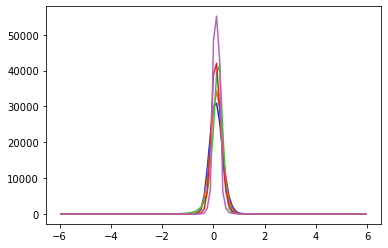

In [6]:
nval = 128*128*10#len(SDS_test)
ret = MB.get_info()
for idx in ret.keys():
    data = ret[idx]
    print(np.sum(data["hist"])/nval)
    plt.plot(data["bin_centers"], data["hist"])

['rad_pts', 'ir_pts', 'tsz', 'ksz', 'kappa']
Original Sehgal sim (64x64) arcmin^2


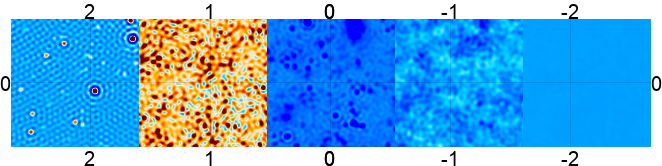

ML Reproduction (64x64) arcmin^2


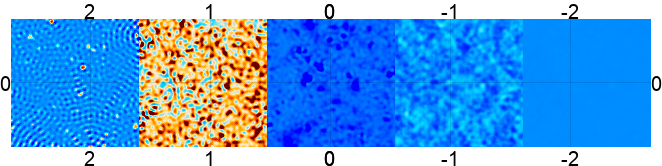

In [109]:
def make_hstrip(array):
    shape = array.shape
    if shape[0] < 2: return array
    else:
        nc, ny, nx = shape
        nnx = nx*nc
        ret = np.zeros((ny, nnx))
        for i in range(nc):
            sx = i*nx
            ret[:,sx:sx+nx] = array[i,...].copy()
        return ret

print(SDN.channel_idxes[::-1])
print("Original Sehgal sim (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(SDS_test[0])), wcs))
print("ML Reproduction (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(DCGAN_WGP.generate_samples(1).data.numpy()[0])), wcs))